In [110]:
# Load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import project_env
from imp import reload

reload(project_env)

%matplotlib inline

**The `project_env` package**

I wrote this python package so loading and working with data is quicker and easier. There are several convenience methods:
* `load_split_bucket(station_id)` - Load data for a bike station that's already pre-split into train, dev and test. Includes doing data cleaning and thresholding. The output is a dictionary:
```
  {
    'train': (DataFrame, Series),
    'dev': (DataFrame, Series),
    'test': (DataFrame, Series),
    'train_times': Series,
    'dev_times': Series,
    'test_times': Series
  }
```
  Each `(DataFrame, Series)` tuple is the feature values and target variables, respectively.
  
  The `train_times` key contains the predicted time (i.e. 11 Nov, 18:30 PM)
* `merge_training(split, df)` - Given two outputs of `load()`, append the training set of the second argument to the training set of the first. This is useful when trying to load data from multiple stations, but testing on one station only.
* `binarize(data, target)` - Given output of `load()` and either 1 or -1, binarize the target variable to 0 or 1. Whatever class is in the second argument will become '1' in the new data.

In [111]:
data = project_env.load_split_bucket(519, target='y_60m', log=False)

In [112]:
training_X, training_y = data['train']

print(len(training_X.columns))
print(training_X.columns)
#training_X.describe().T

22
Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'nearestStormDistance', 'ozone', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed',
       'num_bikes_available_scaled', 'num_bikes_disabled_scaled',
       'num_docks_available_scaled', 'day_of_week', 'hour_of_day',
       'is_weekend', 'traffic_0_speed_scrub', 'traffic_1_speed_scrub',
       'traffic_2_speed_scrub'],
      dtype='object')


In [113]:
def do_logreg(split_data, squares=False, plot=True):
    train_X, train_y = split_data['train']
    dev_X, dev_y = split_data['dev']
    
    logreg = LogisticRegression(C=1e5)
    scaler = sklearn.preprocessing.StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    
    if squares:
        train_X_scaled = np.concatenate([
                train_X_scaled,
                np.square(train_X_scaled)], axis=1)
    print('X shape:', train_X_scaled.shape)
    
    #print(pd.DataFrame(train_X_scaled).describe().T)
    logreg.fit(train_X_scaled, train_y)

    dev_X_scaled = scaler.transform(dev_X)
    if squares:
        dev_X_scaled = np.concatenate([
                dev_X_scaled,
                np.square(dev_X_scaled)], axis=1)
        
    dev_pred = logreg.predict(dev_X_scaled)
    dev_decision = logreg.predict_proba(dev_X_scaled)[:,1]
    acc = sklearn.metrics.accuracy_score(dev_y, dev_pred)
    print('Evaluating on dev set of {} examples'.format(len(dev_y)))
    print('Accuracy:', acc)
    
    print(sklearn.metrics.confusion_matrix(dev_y, dev_pred))

    if plot:
        plt.figure()
        plt.plot(dev_y.as_matrix()[100:500], 'b')
        plt.plot(dev_pred[100:500], 'g')
        plt.plot(0.5 * (dev_y.as_matrix() - dev_pred)[100:500], 'r')
        plt.ylim(-3, 3)
        plt.show()
    
    return logreg, scaler, dev_decision

X shape: (4236, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.810950413223
[[443 142]
 [ 41 342]]


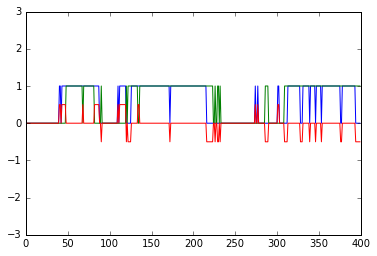

In [114]:
data_empty = project_env.binarize(data, -1)
logreg, scaler, dev_pred = do_logreg(data_empty)

In [115]:
# Add in data from PS south (517) - capacity 59
def read_more_data(station_id):
    return project_env.load_split_bucket(station_id, target='y_60m')

more = read_more_data(446)
more['train'][0].describe().T

,count,mean,std,min,25%,50%,75%,max
apparentTemperature,3470.0,56.461121,11.135650,30.55,49.350000,56.000000,63.910000,84.620000
cloudCover,3470.0,0.312738,0.274608,0.00,0.100000,0.240000,0.440000,1.000000
dewPoint,3470.0,43.642150,11.880622,23.02,34.392500,40.455000,54.600000,68.490000
humidity,3470.0,0.617467,0.147458,0.28,0.500000,0.610000,0.710000,0.950000
nearestStormDistance,3470.0,88.269741,136.935464,0.00,8.000000,24.000000,114.000000,1011.000000
ozone,3470.0,279.265147,14.469534,246.79,270.082500,276.490000,288.480000,315.310000
precipIntensity,3470.0,0.000567,0.004458,0.00,0.000000,0.000000,0.000000,0.115700
precipProbability,3470.0,0.026591,0.147329,0.00,0.000000,0.000000,0.000000,1.000000
pressure,3470.0,1015.490049,34.758484,419.85,1012.520000,1018.450000,1023.070000,1031.010000
temperature,3470.0,57.311816,10.017919,36.75,49.990000,56.000000,63.910000,83.620000


X shape: (7706, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.808884297521
[[447 138]
 [ 47 336]]


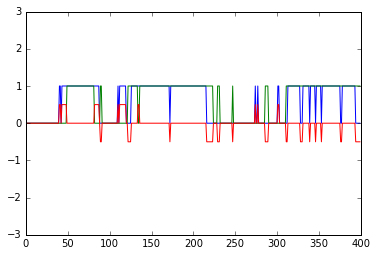

In [116]:
appended = project_env.merge_training(data, more)
appended_empty = project_env.binarize(appended, -1)

a_logreg, a_scaler, a_pred = do_logreg(appended_empty)

In [117]:
# Go nuts with adding more training data.
station_ids_to_concat = [446, 320, 3263, 285, 435, 477]
station_ids_data = [read_more_data(sid) for sid in station_ids_to_concat]

In [118]:
app_len = len(appended['train'][0])
more_appended = appended
for df in station_ids_data:
    more_appended = project_env.merge_training(more_appended, df)
    
assert len(appended['train'][0]) == app_len

X shape: (32221, 22)
Evaluating on dev set of 968 examples
Accuracy: 0.798553719008
[[447 138]
 [ 57 326]]


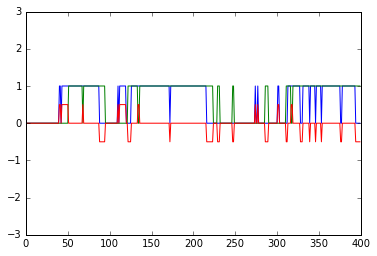

In [119]:
more_appended_empty = project_env.binarize(more_appended, -1)
sq, scl, more_appended_pred = do_logreg(more_appended_empty)

X shape: (4236, 44)
Evaluating on dev set of 968 examples
Accuracy: 0.601239669421
[[222 363]
 [ 23 360]]


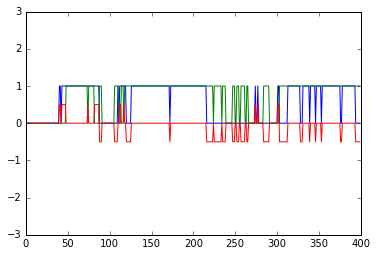

In [120]:
sq, scl, basic_pred_sq = do_logreg(data_empty, squares=True)

# Evaluation

Plot the precision-recall curve for the 4 classifiers:

Model baseline
  Max precision: 0.528301886792 at recall 0.950391644909
  Threshold of max precision: 0.540983606557
Model basic
  Max precision: 0.581469648562 at recall 0.950391644909
  Threshold of max precision: 0.237080416325
Model appended
  Max precision: 0.547368421053 at recall 0.950391644909
  Threshold of max precision: 0.160068204392
Model more_appended
  Max precision: 0.536873156342 at recall 0.950391644909
  Threshold of max precision: 0.0707310627155
Model basic_sq
  Max precision: 0.480895915679 at recall 0.953002610966
  Threshold of max precision: 0.387412943013


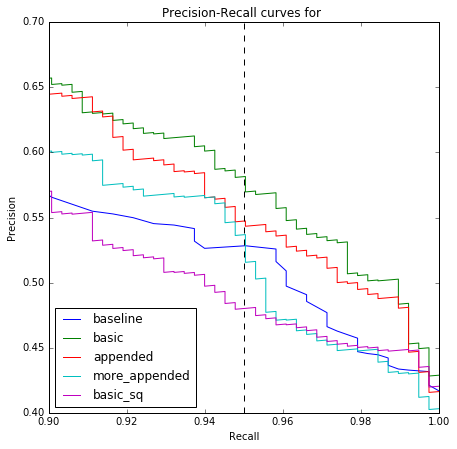

In [121]:
from sklearn.metrics import precision_recall_curve

gold_labels = data_empty['dev'][1]

def pr_curve(predictions, label, plot=True):
    curve = precision_recall_curve(gold_labels, predictions)
    precision, recall, thresholds = curve
    mp, mr, mt = project_env.max_precision_for_recall(curve)
    predicted_classes = predictions > mt
    print('Model', label)
    print('  Max precision:', mp, 'at recall', mr)
    print('  Threshold of max precision:', mt)
    plt.plot(recall, precision, label=label)
    return predicted_classes
   
plt.figure(figsize=(7, 7))
pr_curve(data_empty['dev'][0]['num_docks_available_scaled'], 'baseline')
predicted_basic = pr_curve(dev_pred, 'basic')
pr_curve(a_pred, 'appended')
pr_curve(more_appended_pred, 'more_appended')
pr_curve(basic_pred_sq, 'basic_sq')

plt.xlim([0.9, 1.0])
plt.ylim([0.4, 0.7])
plt.axvline(x=0.95, color='k', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.title('Precision-Recall curves for ')
plt.show()

95% recall means that whenever the model tells a user to go to a station to pick up a bike at a designated time, 5% of the time, the station ends up empty (the bad case).

Given a model satisfies at least 95% recall, a higher precision means fewer occasions where a model turns the user away from the station even though it has bikes available (a more efficient model). So, we want to find a model that maximizes precision given a minimum recall.

In the plot above the `basic` model wins out at around 57% precision at 95% recall. So that means when the model says the station is empty, 57% of the time the station will actually be empty.

# Running on a date range

Run on the dev set range

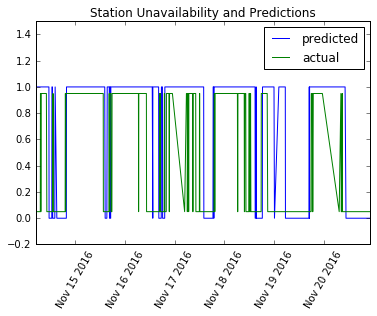

In [122]:
def plot_over_time(data, predictions):
    times = data['dev_times']
    gold_labels = data['dev'][1]
    
    curve = precision_recall_curve(gold_labels, predictions)
    mp, mr, mt = project_env.max_precision_for_recall(curve)
    predicted_classes = predictions > mt
    
    plt.figure()
    plt.plot(times.as_matrix(), predicted_classes, label='predicted')
    plt.plot(times.as_matrix(), gold_labels.as_matrix() * 0.9 + 0.05, label='actual')
    plt.title('Station Unavailability and Predictions')
    plt.legend()
    plt.xticks(rotation=60)
    plt.ylim(-0.2, 1.5)
    plt.show()

plot_over_time(data_empty, dev_pred)